In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pandas.plotting import scatter_matrix
from scipy.stats import chi2_contingency
from helpers import categorical_univariate , categorical_bivariate
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import ttest_ind
from pandas.core.base import duplicated
import seaborn as sns

from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_csv('Employee.csv')
data

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0     Bachelors         2017  Bangalore            3   34    Male          No   
1     Bachelors         2013       Pune            1   28  Female          No   
2     Bachelors         2014  New Delhi            3   38  Female          No   
3       Masters         2016  Bangalore            3   27    Male          No   
4       Masters         2017       Pune            3   24    Male         Yes   
...         ...          ...        ...          ...  ...     ...         ...   
4648  Bachelors         2013  Bangalore            3   26  Female          No   
4649    Masters         2013       Pune            2   37    Male          No   
4650    Masters         2018  New Delhi            3   27    Male          No   
4651  Bachelors         2012  Bangalore            3   30    Male         Yes   
4652  Bachelors         2015  Bangalore            3   33    Male         Yes   

      ExperienceInCurrentDomain  LeaveOrNot  
0                             0           0  
1                             3           1  
2                             2           0  
3                             5           1  
4                             2           1  
...                         ...         ...  
4648                          4           0  
4649                          2           1  
4650                          5           1  
4651                          2           0  
4652                          4           0  

[4653 rows x 9 columns]

In [3]:
data=data.drop(columns=("EverBenched"))

In [4]:
data.describe()

JoiningYear  PaymentTier          Age  ExperienceInCurrentDomain  \
count  4653.000000  4653.000000  4653.000000                4653.000000   
mean   2015.062970     2.698259    29.393295                   2.905652   
std       1.863377     0.561435     4.826087                   1.558240   
min    2012.000000     1.000000    22.000000                   0.000000   
25%    2013.000000     3.000000    26.000000                   2.000000   
50%    2015.000000     3.000000    28.000000                   3.000000   
75%    2017.000000     3.000000    32.000000                   4.000000   
max    2018.000000     3.000000    41.000000                   7.000000   

        LeaveOrNot  
count  4653.000000  
mean      0.343864  
std       0.475047  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [5]:
data['LeaveOrNot'].value_counts()

0    3053
1    1600
Name: LeaveOrNot, dtype: int64

In [6]:
duplicates_rows = data[data.duplicated()]
print ("Duplicated rows are :")
duplicates_rows

Duplicated rows are :


Education  JoiningYear       City  PaymentTier  Age  Gender  \
111   Bachelors         2017       Pune            2   27  Female   
130   Bachelors         2017  Bangalore            3   26  Female   
138   Bachelors         2017  New Delhi            3   28    Male   
160   Bachelors         2014  Bangalore            3   28  Female   
167   Bachelors         2014  Bangalore            3   25    Male   
...         ...          ...        ...          ...  ...     ...   
4646  Bachelors         2013  Bangalore            3   25  Female   
4648  Bachelors         2013  Bangalore            3   26  Female   
4650    Masters         2018  New Delhi            3   27    Male   
4651  Bachelors         2012  Bangalore            3   30    Male   
4652  Bachelors         2015  Bangalore            3   33    Male   

      ExperienceInCurrentDomain  LeaveOrNot  
111                           5           1  
130                           4           0  
138                           2           0  
160                           3           0  
167                           3           0  
...                         ...         ...  
4646                          3           0  
4648                          4           0  
4650                          5           1  
4651                          2           0  
4652                          4           0  

[2098 rows x 8 columns]

In [7]:
duplicate_count = data[data.duplicated()].shape[0]

# Print the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 2098


In [8]:
# Remove duplicate rows and update 'data'
data = data.drop_duplicates()

# If you want to reset the index after removing duplicates
data.reset_index(drop=True, inplace=True)

In [9]:
duplicates_rows = data[data.duplicated()]
print ("Duplicated rows are :")
duplicates_rows

Duplicated rows are :


Empty DataFrame
Columns: [Education, JoiningYear, City, PaymentTier, Age, Gender, ExperienceInCurrentDomain, LeaveOrNot]
Index: []

In [10]:
# Function to Apply test statistic for all categorical colunms
def test_statistic (column_name) :
  # Create Contingency Table
  contingency_table = pd.crosstab(data[column_name], data['LeaveOrNot'])
  print("Our table ",contingency_table)

  # Perform Chi-squared Test
  chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
  print(f"Chi-squared Statistic: {chi2_stat}")
  print(f"P-value: {p_val}")
  print(f"Degrees of Freedom: {dof}")
  print("Expected Frequencies:")
  print(expected)

In [11]:
test_statistic ("Education")

Our table  LeaveOrNot     0    1
Education            
Bachelors   1115  685
Masters      316  284
PHD          115   40
Chi-squared Statistic: 29.14194876342623
P-value: 4.6979266319467485e-07
Degrees of Freedom: 2
Expected Frequencies:
[[1089.15851272  710.84148728]
 [ 363.05283757  236.94716243]
 [  93.78864971   61.21135029]]


In [12]:
test_statistic ("City")

Our table  LeaveOrNot    0    1
City                
Bangalore   682  380
New Delhi   494  248
Pune        370  381
Chi-squared Statistic: 57.26352247717002
P-value: 3.676072659961153e-13
Degrees of Freedom: 2
Expected Frequencies:
[[642.6035225  419.3964775 ]
 [448.97534247 293.02465753]
 [454.42113503 296.57886497]]


In [13]:
test_statistic ("Gender")

Our table  LeaveOrNot    0    1
Gender              
Female      581  581
Male        965  428
Chi-squared Statistic: 97.69447939593573
P-value: 4.8818154418592804e-23
Degrees of Freedom: 1
Expected Frequencies:
[[703.11232877 458.88767123]
 [842.88767123 550.11232877]]


In [14]:
# Select numeric values
numeric_df = data.select_dtypes(include='number')
id = numeric_df ['LeaveOrNot']
numeric_df.drop ("LeaveOrNot", axis =1,inplace=True  )
age = numeric_df ['Age']
numeric_df.drop ("Age", axis =1,inplace=True )

JoiningYear


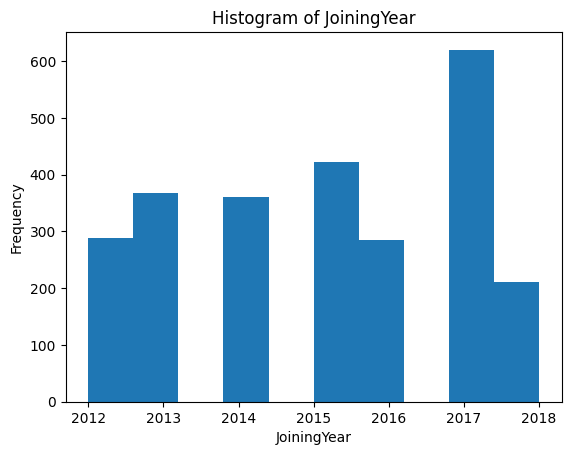

PaymentTier


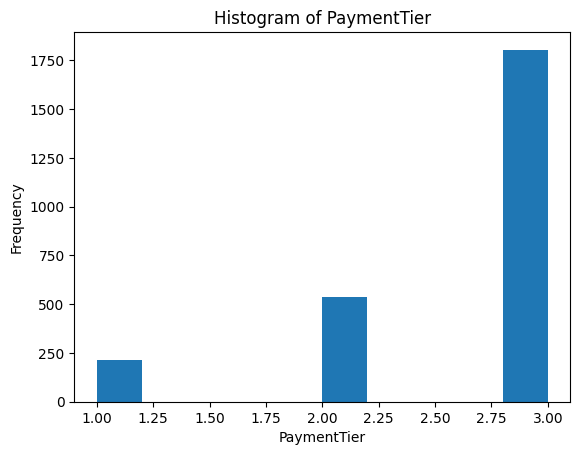

ExperienceInCurrentDomain


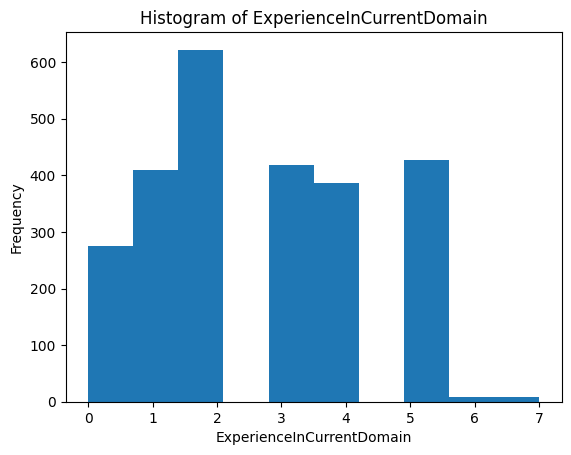

In [15]:
# Univariate analysis - Histograms distributions
for column in numeric_df.columns:
    plt.figure()
    print (column)
    numeric_df[column].plot(kind='hist', bins=10)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

JoiningYear


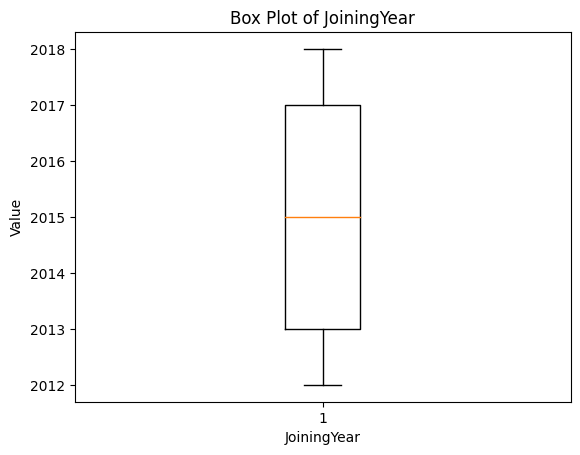

PaymentTier


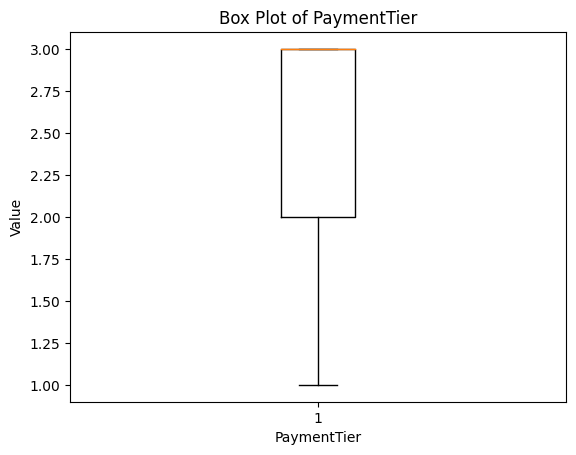

ExperienceInCurrentDomain


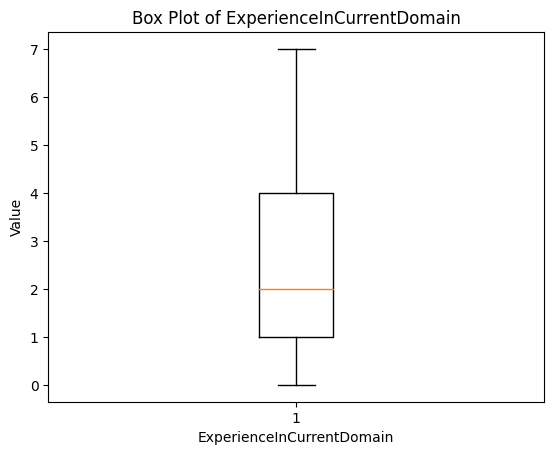

In [16]:
for column in numeric_df.columns:
    plt.figure()
    print(column)
    plt.boxplot(numeric_df[column])
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Box Plot of {column}')
    plt.show()

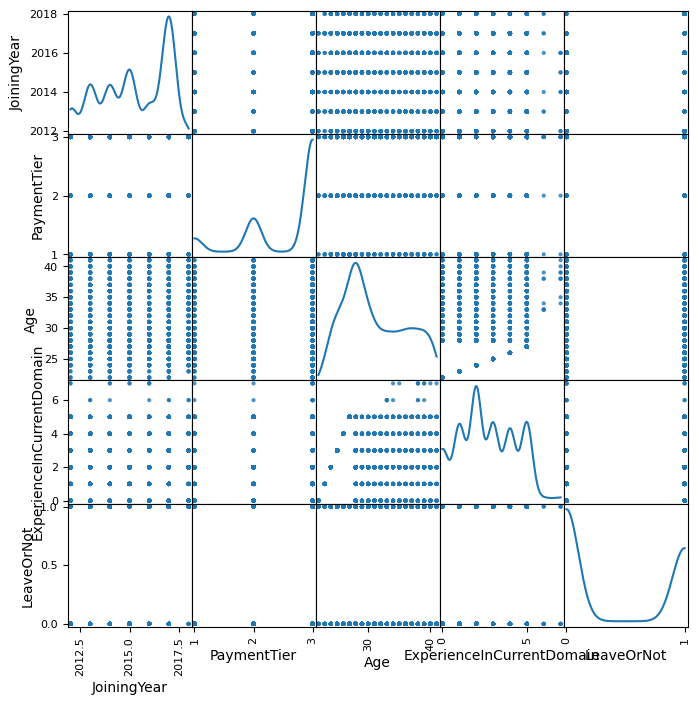

In [17]:
# Check for Multicollinearity
scatter_matrix(data , alpha=0.8, figsize=(8, 8), diagonal='kde')
plt.show()

In [18]:
def plot_skewness_all_features(df):
    num_features = df.select_dtypes(include=['float64', 'int64'])  # Select numerical features
    num_cols = num_features.columns
    num_cols_count = len(num_cols)
    num_rows = math.ceil(num_cols_count / 2)

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 8))
    fig.tight_layout(pad=3.0)

    for i, col in enumerate(num_cols):
        ax = axes[i // 2, i % 2] if num_cols_count > 1 else axes[i % 2]
        sns.distplot(df[col], ax=ax, label=f"Skewness: {df[col].skew():.2f}")
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.show()

<ipython-input-18-9b6fa234317d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax, label=f"Skewness: {df[col].skew():.2f}")
<ipython-input-18-9b6fa234317d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax, label=f"Skewness: {df[col].skew():.2f}")
<ipython-input-18-

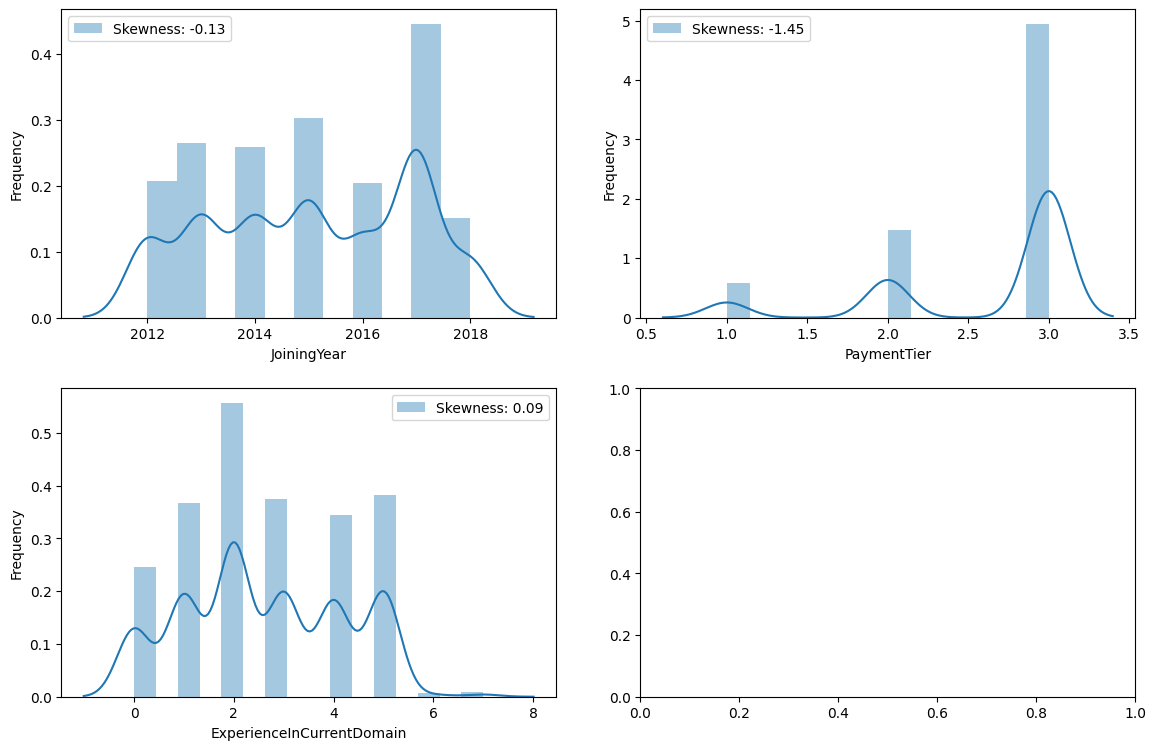

In [19]:
plot_skewness_all_features(numeric_df)

In [20]:
def test_numeric_features(df, numeric_columns, target_column):
    results = {}
    for column in numeric_columns:
        category_0 = df[column][df[target_column] == 0]
        category_1 = df[column][df[target_column] == 1]
        # Perform t-test
        statistic, p_value = ttest_ind(category_0, category_1)
        results[column] = p_value

    return results

In [21]:
num_cols=numeric_df.columns

In [22]:
results = test_numeric_features(data, numeric_columns=num_cols, target_column='LeaveOrNot')
print(results)

{'JoiningYear': 6.4442957963150105e-12, 'PaymentTier': 4.706212889088187e-08, 'ExperienceInCurrentDomain': 0.2098540613547004}


In [23]:
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

In [24]:
data = pd.get_dummies(data,drop_first=True)

In [25]:
X = data.drop(columns=['LeaveOrNot'])
y = data['LeaveOrNot']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [27]:
# Automatically split columns into categorical and numeric
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [28]:
# Create transformers
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [29]:
# Combine transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),('cat', categorical_transformer, categorical_cols)] ,remainder='passthrough')

In [30]:
# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [31]:
# Balance the classes using RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [190]:
# Define a function to create and compile your DNN model
def create_dnn_model(learning_rate=0.01, dropout_rate=0.4, l2_strength=0.001):
    model = keras.Sequential([
        layers.Input(shape=(X_train_resampled.shape[1],)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [191]:
# Define hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.3, 0.4]
l2_strengths = [0.001, 0.01, 0.1]

best_accuracy = 0.0
best_hyperparameters = {}

In [193]:
#Perform a grid search
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for l2_strength in l2_strengths:
            model = create_dnn_model(learning_rate, dropout_rate, l2_strength)
            model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.3, verbose=0, callbacks=[early_stopping])
            y_pred = model.predict(X_test)
            y_pred_binary = (y_pred > 0.5).astype(int)
            accuracy = accuracy_score(y_test, y_pred_binary)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = {
                    'learning_rate': learning_rate,
                    'dropout_rate': dropout_rate,
                    'l2_strength': l2_strength
                }

16/16 [==============================] - 0s 2ms/step


In [195]:
print("Best Hyperparameters:", best_hyperparameters)
print("Best Test Accuracy:", best_accuracy)

Best Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'l2_strength': 0.001}
Best Test Accuracy: 0.7984344422700587


In [52]:
# Define and compile your DNN model with regularization, dropout, batch normalization, and more hidden layers/neurons
model = keras.Sequential([
    layers.Input(shape=(X_train_resampled.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [53]:
# Use a learning rate schedule to gradually reduce the learning rate
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate / (10 ** (epoch // 10)))

In [54]:
# Compile the model with the RMSprop optimizer
model.compile(optimizer=RMSprop(learning_rate=initial_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [82]:
# Train the model with early stopping based on validation loss
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.99)
#, callbacks=[lr_schedule, early_stopping]

Epoch 1/100
2/2 [==============================] - 0s 256ms/step - loss: 0.4188 - accuracy: 0.8108 - val_loss: 0.4229 - val_accuracy: 0.8567
Epoch 2/100
2/2 [==============================] - 0s 222ms/step - loss: 0.5064 - accuracy: 0.8108 - val_loss: 0.4230 - val_accuracy: 0.8570
Epoch 3/100
2/2 [==============================] - 0s 336ms/step - loss: 0.3556 - accuracy: 0.8919 - val_loss: 0.4232 - val_accuracy: 0.8573
Epoch 4/100
2/2 [==============================] - 0s 353ms/step - loss: 0.3973 - accuracy: 0.8378 - val_loss: 0.4232 - val_accuracy: 0.8567
Epoch 5/100
2/2 [==============================] - 0s 337ms/step - loss: 0.4081 - accuracy: 0.8919 - val_loss: 0.4233 - val_accuracy: 0.8562
Epoch 6/100
2/2 [==============================] - 0s 224ms/step - loss: 0.3189 - accuracy: 0.8919 - val_loss: 0.4233 - val_accuracy: 0.8559
Epoch 7/100
2/2 [==============================] - 0s 235ms/step - loss: 0.4854 - accuracy: 0.8649 - val_loss: 0.4235 - val_accuracy: 0.8564
Epoch 8/100
2

In [83]:
# Calculate accuracy on the training set
y_train_pred = model.predict(X_train_resampled)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_binary)
print(f'Training Accuracy: {train_accuracy:.2f}')

153/153 [==============================] - 0s 2ms/step
Training Accuracy: 0.80


In [84]:
# Calculate accuracy on Train set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test Accuracy: {accuracy:.2f}')

30/30 [==============================] - 0s 2ms/step
Test Accuracy: 0.83


In [86]:
# Print classification report for more detailed evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       611
           1       0.88      0.59      0.71       320

    accuracy                           0.83       931
   macro avg       0.85      0.77      0.79       931
weighted avg       0.84      0.83      0.82       931

